In [18]:
## CE 295 - Energy Systems and Control
# HW 2 : State Estimation in Geothermal Heat Pump Drilling
# Oski Bear, SID 18681868
# Prof. Moura
# Due Date is written here

# BEAR_OSKI_HW2.ipynb

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import interp
from scipy import signal
%matplotlib inline
from __future__ import division
import pandas as pd
import control # Read http://python-control.sourceforge.net/manual/

fs = 15 # Font Size for plots

# Drill String Parameters

J_T = 100  # Table/top rotational inertia
J_B = 25   # Bottom/bit rotational inertia
k = 2     # Spring constant
b = 5     # Drag coefficient

Problem 1: 

- A: Define & write the modeling objective. What are the controllable and uncontrollable inputs? What are the measured and performance outputs? List the parameters.
  - Objective: The modeling objective is to estimate the drill bit velocity
  - State Variable, `x`:
    - w_T, viscous drag, top
    - w_B, viscous drag, bottom
    - $\theta_T$
    - $\theta_B$
  - Controllable Inputs, `u`:
    - T, Torque
  - uncontrollable Inputs, $\omega$:
    - T_f, 
  - Measured Outputs, `y`:
    - Table/Top rotation, w_T
  - Performance Outputs, `z`:
    - $\omega_B$
  - Parameters, $\theta$:
    - b, coeff of drag
    - k, spring coeff (**?**)
    - J_T
    - J_B
- B: Use Newton’s second law in rotational coordinates to derive the equations of motion for the top/table and bottom/bit portions of the drill string. HINT: Fig 2 is a free body diagram.
  - $\frac{d\omega_T}{dt} = {\tau(t) - b\omega_{T}(t) - k [\theta_{T}(t)- \theta_{B}(t)]}\frac{1}{J_T}$ 
  - $\frac{d\omega_B}{dt} = {-\tau(t) - b\omega_{B}(t) - k [\theta_{T}(t)- \theta_{B}(t)]}\frac{1}{J_B}$ 
  - $\frac{d\theta_T}{dt} = \omega_T$
  - $\frac{d\theta_B}{dt} = \omega_B$
- C: Write all the dynamical equations into matrix state space form. What are the A, B, C matrices? Hint: A ∈ R4×4
  
$$
\frac{d}{dt}
\begin{bmatrix} \omega_T \\ \omega_B \\ \theta_T \\ \theta_B\end{bmatrix} 
= 
\begin{bmatrix} \frac{-b}{J_T} & 0 & \frac{-k}{J_T} & \frac{k}{J_T} \\ 0 & \frac{-b}{J_B} & \frac{k}{J_B} & \frac{-k}{J_B} \\ 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \end{bmatrix} 
\begin{bmatrix} \\ \omega_T \\ \omega_B \\ \theta_T \\ \theta_B \end{bmatrix} 
+
\begin{bmatrix} \frac{1}{J_T} & 0\\ 0 & \frac{-1}{J_B} \\ 0 & 0 \\ 0 & 0 \end{bmatrix}
\begin{bmatrix} \tau \\ \tau_f \end{bmatrix}
$$

$C = \omega_T = \begin{bmatrix}1 & 0 & 0 & 0\end{bmatrix}$



Problem 2:

A:
 - $O = \begin{bmatrix} C \\
                      CA \\
                      CA^{2}\\
                      CA^{3}
\end{bmatrix}$

 - Because rank(O) = 3 < than the n states, not all states are observable. 

B:
$\frac{d}{dt}
\begin{bmatrix} \omega_T \\ \omega_B \\ \theta\end{bmatrix} 
= 
\begin{bmatrix} \frac{-b}{J_T} & 0 & \frac{k}{J_T} \\
                0 & \frac{-b}{J_B} & \frac{-k}{J_B} \\
                1 & -1 & 0  
\end{bmatrix} 
\begin{bmatrix} \omega_T \\ 
                \omega_B \\ 
                \theta 
\end{bmatrix} 
+
\begin{bmatrix} \frac{1}{J_T} & 0 \\ 
                0 & \frac{-1}{J_B} \\ 
                0 & 0
\end{bmatrix}
\begin{bmatrix} \tau \\
                \tau_f
\end{bmatrix}
$

 - $C = \omega_T = \begin{bmatrix}1 & 0 & 0 & 0\end{bmatrix}$


C:
 - $O = \begin{bmatrix} C \\
                      CA \\
                      CA^{2}\\
\end{bmatrix}$

  - Now that rank(O) = 3 == n states, the system is now considered observable


In [19]:
## Problem 2 - Observability Analysis

# State space matrices
A4 = np.matrix([[-b/J_T,0,-k/J_T,k/J_T], 
                [0,-b/J_B,k/J_B,-k/J_B], 
                [1,0,0,0], 
                [0,1,0,0]])

B4 = np.matrix([[1/J_T,0],
                [0,-1/J_B],
                [0,0],
                [0,0]])

C4 = np.matrix([[1,0,0,0]])

# Compute observability Matrix for 4-state system and rank
O4 = control.obsv(A4,C4)
print('Rank of Observability Matrix for four-state system')
print(np.linalg.matrix_rank(O4))

# New A Matrix, for 3-state system
A = np.matrix([[-b/J_T,0,-k/J_T],
               [0,-b/J_B,k/J_B],
               [1,-1,0]
             ])

B = np.matrix([[1/J_T],
               [0],
               [0]
              ])

C = np.matrix([[0,1,0]])

D = np.matrix([0]) #Add empty D for Q4 

# Observability Matrix for 3-state system and rank
O = control.obsv(A,C)
print('Rank of Observability Matrix for three-state system')
print(np.linalg.matrix_rank(O))

Rank of Observability Matrix for four-state system
3
Rank of Observability Matrix for three-state system
3


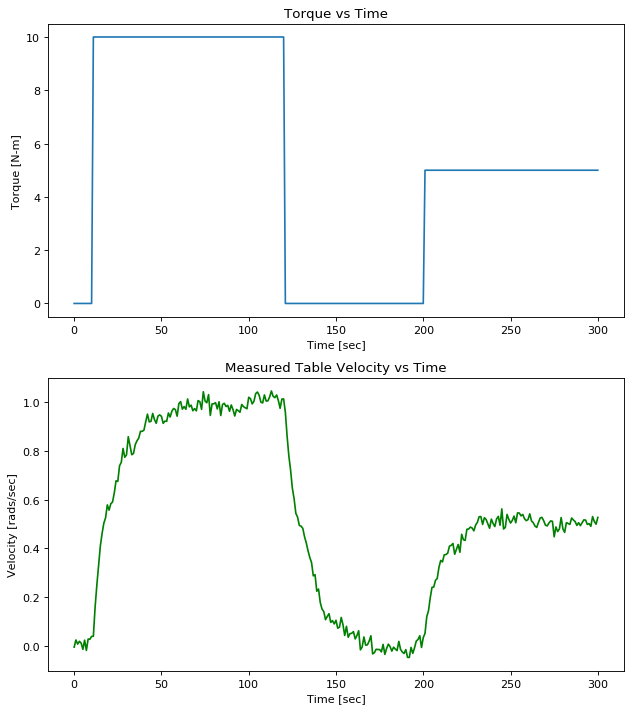

In [20]:
## Load Data
data=np.asarray(pd.read_csv("HW2_Data.csv",header=None))

t = data[:,0]      # t   : time vector [sec]
y_m = data[:,1]    # y_m : measured table velocity [radians/sec]
Torq = data[:,2]   # Torq: table torque [N-m]
omega_B_true = data[:,3] # \omega_B : true rotational speed of bit [radians/sec]

# Plot Data
plt.figure(num=1, figsize=(8, 9), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2,1,1)
plt.plot(t, Torq)
plt.ylabel('Torque [N-m]')
plt.xlabel('Time [sec]')
plt.title('Torque vs Time')
# Plot table torque

plt.subplot(2,1,2)
plt.plot(t, y_m, color='g')
plt.ylabel('Velocity [rads/sec]')
plt.xlabel('Time [sec]')
plt.title('Measured Table Velocity vs Time')
plt.tight_layout()
# Plot measured table velocity

plt.show()

Problem 4:

A: Re(Eigenvalues of A): -0.08322949,-0.08338525,-0.08338525
  
  $
  \dot{\hat{x}} = A\hat{x}(t) + Bu(t) + L[y(t) - \hat{y}(t)] \\
  \hat{y} = C\dot{\hat{x}}(t) + Du(t) \\
  $
  simplify $\dot{\hat{x}}$
  
  1. Distribute L, subsitute in full form of $\hat{y}(t)$:
  $
  \dot{\hat{x}} = A\hat{x}(t) + Bu(t) + Ly(t) - L\hat{y}(t) \\
  \dot{\hat{x}} = A\hat{x}(t) + Bu(t) + Ly(t) - L[C\dot{\hat{x}}(t) + Du(t)]
  $

  2. Distribute L again:
  $
  \dot{\hat{x}} = A\hat{x}(t) - LC\dot{\hat{x}}(t) + Bu(t) - LDu(t)] + Ly(t)
  $
  
B:
  - Re(Eigenvalues of A): [-0.08322949,-0.08338525,-0.08338525]
  - Re(Selected Eigenvalues): $\lambda_i = $ [-0.4993769, -0.50031153,-0.50031153]
    - derived from the original eigenvalues * 6, in line with the "general rule of thumb" that they should be ~2-12x faster than the slowest. If too fast, they will amplify noise.
  
C:
  - using the equations derived in 4.A:
  $$
  \begin{bmatrix} \dot{\hat{x}} \end{bmatrix}
  = \begin{bmatrix} A-LC \end{bmatrix} \begin{bmatrix} \hat{x} \end{bmatrix} + 
  \begin{bmatrix}B-LD,L\end{bmatrix}\begin{bmatrix}u \\ y \end{bmatrix}
  $$

  $$
  \begin{bmatrix} \hat{y} \end{bmatrix} = \begin{bmatrix} C \end{bmatrix}\begin{bmatrix} \hat{x}  \end{bmatrix} + \begin{bmatrix} D \end{bmatrix} \begin{bmatrix} u \\ y \end{bmatrix}
  $$

D: see plot below

Eigenvalues of open-loop system:
[-0.08322949+0.j         -0.08338525+0.29860789j -0.08338525-0.29860789j]
Luenberger RMSE: 0.08330893264223327 rad/s


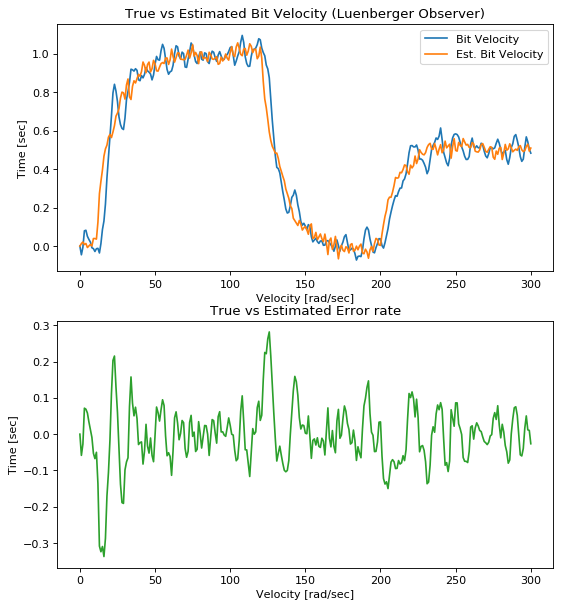

In [59]:
## Problem 4 - Luenberger Observer

# Eigenvalues of open-loop system
print('Eigenvalues of open-loop system:')
lam_A,evec = np.linalg.eig(A)
print(lam_A)

# Desired poles of estimation error system
#   They should have negative real parts
#   Complex conjugate pairs
lam_luen = lam_A * 6

# Compute observer gain (See Remark 3.1 in Notes. Use "acker" command)
L = control.acker(A.T,C.T,lam_luen).T

# State-space Matrices for Luenberger Observer
A_lobs = (A - L*C)
B_lobs = np.hstack((B - L*D, L))#TODO HELP 
C_lobs = C
D_lobs = np.matrix([[0,0]])

sys_lobs = signal.lti(A_lobs,B_lobs,C_lobs,D_lobs)

# Inputs to observer
u = np.array([Torq, y_m]).T

# Initial Conditions
x_hat0 = [0,0,0]

# Simulate Response
tsim, y, x_hat = signal.lsim(sys_lobs, U=u, T=t, X0=x_hat0)

# Parse states
theta_hat = x_hat[:,2]
omega_T_hat = x_hat[:,0]
omega_B_hat = x_hat[:,1]

#Add RMS
luen_est_err = omega_B_true-omega_B_hat
RMSE = np.sqrt(np.mean(np.power(omega_B_true-omega_B_hat,2)))
print('Luenberger RMSE: ' + str(RMSE) + ' rad/s')

# Plot Results
plt.figure(num=1, figsize=(8, 9), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2,1,1)
# Plot true and estimated bit velocity
plt.plot(t,omega_B_true, 'C0',label='Bit Velocity')
plt.plot(t,omega_B_hat, 'C1', label='Est. Bit Velocity')

plt.xlabel('Velocity [rad/sec]')
plt.ylabel('Time [sec]')
plt.title('True vs Estimated Bit Velocity (Luenberger Observer)')
plt.legend()
plt.subplot(2,1,2)
# Plot error between true and estimated bit velocity
plt.plot(t,luen_est_err, 'C2')

plt.xlabel('Velocity [rad/sec]')
plt.ylabel('Time [sec]')
plt.title('True vs Estimated Error rate')

plt.show()

Problem 5:

- A: See Ch2.4.45-48
- B: Using the identity matrix as a starting point, I simply tuned  by testing different values till I found the lowest RMSE, while checking against the graphs to spot check for sanity. I settled on 0.005 as a reasonable value.
- C: See plots below
- D: `Re(Selected Luenberger Eigenvalues): λi= -0.4993769, -0.50031153,-0.50031153` vs `Re(KF Eigenvalues): λi= -0.49937695, -0.50031153, -0.50031153.`They are nearly exactly the same, which makes sense since if the system is asymptotically stable, KF should work towards these Eigenvalues with enough time.


Kalman Filter RMSE: 0.05550876089085813 rad/s


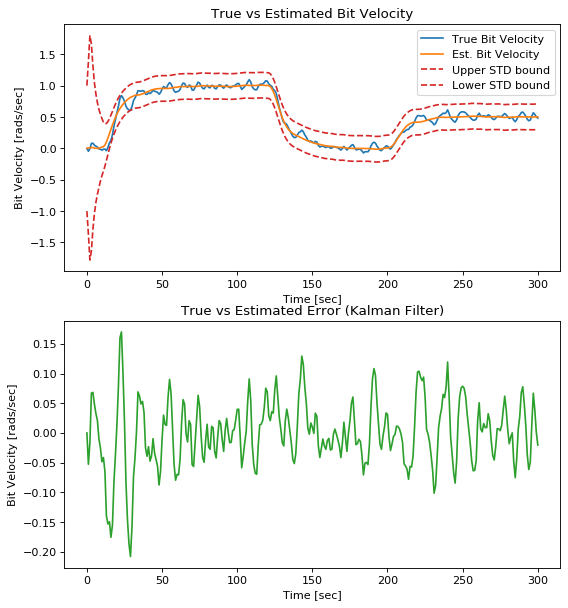

In [58]:
## Problem 5 - Kalman Filter
# Noise Covariances
W =  .0005 * np.identity(3)# Should be 3x3 because of the # of x states 
N =  .02
Sig0 = np.identity(3)

# Initial Condition
x_hat0 = [0,0,0]
states0 = np.r_[x_hat0, np.squeeze(np.asarray(Sig0.reshape(9,1)))]

# Ordinary Differential Equation for Kalman Filter
def ode_kf(z,it):
    
    # Parse States
    x_hat = np.matrix(z[:3]).T
    Sig = np.matrix((z[3:]).reshape(3,3))
    
    # Interpolate input signal data
    iTorq = interp(it, t, Torq)
    iy_m = interp(it, t, y_m)
    
    # Compute Kalman Gain
    L = Sig * C.T * (1/N)
    
    # Kalman Filter
    x_hat_dot = A * x_hat + B * iTorq + L * (iy_m - (C * x_hat))
    
    # Riccati Equation
    Sig_dot = Sig * A.T + A * Sig + W - Sig * C.T * (1/N) * C * Sig
    
    # Concatenate LHS
    z_dot = np.r_[x_hat_dot, Sig_dot.reshape(9,1)]
    
    return(np.squeeze(np.asarray(z_dot)))


# Integrate Kalman Filter ODEs
z = odeint(ode_kf, states0, t)

# Parse States
theta_hat = z[:,2]
omega_T_hat = z[:,0]
omega_B_hat = z[:,1]
Sig33 = z[:,11]      # Parse out the (3,3) element of Sigma only!

omega_B_tilde = omega_B_true - omega_B_hat
omega_B_hat_upperbound = omega_B_hat + np.sqrt(Sig33)
omega_B_hat_lowerbound = omega_B_hat - np.sqrt(Sig33)

RMSE = np.sqrt(np.mean(np.power(omega_B_tilde,2)))
print('Kalman Filter RMSE: ' + str(RMSE) + ' rad/s')


# Plot Results
plt.figure(num=3, figsize=(8, 9), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2,1,1)
#   Plot true and estimated bit velocity
plt.plot(t,omega_B_true,'C0', label='True Bit Velocity')
plt.plot(t,omega_B_hat, 'C1', label='Est. Bit Velocity')
plt.plot(t,omega_B_hat_upperbound, 'C3--', label='Upper STD bound')
plt.plot(t,omega_B_hat_lowerbound, 'C3--', label='Lower STD bound')

plt.title('True vs Estimated Bit Velocity')
plt.xlabel('Time [sec]')
plt.ylabel('Bit Velocity [rads/sec]')
plt.legend()
#   Plot estimated bit velocity plus/minus one sigma

plt.subplot(2,1,2)
#   Plot error between true and estimated bit velocity
plt.plot(t,omega_B_tilde, 'C2')
plt.title('True vs Estimated Error (Kalman Filter)')
plt.xlabel('Time [sec]')
plt.ylabel('Bit Velocity [rads/sec]')

plt.show()

Problem 6:

A: Use the original 3-equation ODE system, but replace the $k\theta$ term to reflect the nonlinear equations.  
  - $\frac{d\theta}{dt} = \omega_{T} - \omega_{B}$
  - $\frac{dw_T}{dt} = {\tau(t) - b\omega_{T}(t) -[k_{1}\theta(t) + k_{2}\theta^{3}(t)]}\frac{1}{J_T}$
  - $\frac{dw_B}{dt} = {-\tau(t) - b\omega_{B}(t) - [k_{1}\theta(t) + k_{2}\theta^{3}(t)]}\frac{1}{J_B}$ 
  - $\frac{d\omega_T}{dt} = \omega_T$
  - $\frac{d\omega_B}{dt} = \omega_B$
  
  Create F(t) and H(t) matrices: 
   - $F(t)= \begin{bmatrix} 
   0 & 1 & -1 \\
   \frac{-k_{1}}{J_T} - \frac{3k_{2}}{J_B}\theta^{2} & \frac{-b}{J_T} & 0 \\
   \frac{k_{1}}{J_T} + \frac{3k_{2}}{J_B}\theta^{2} & 0 & \frac{-b}{J_B}\\
   \end{bmatrix}$
   - $H(t)= \begin{bmatrix} 0 & 1 & 0 \end{bmatrix}$
  

Extended Kalman Filter RMSE: 0.047802339347738663 rad/s


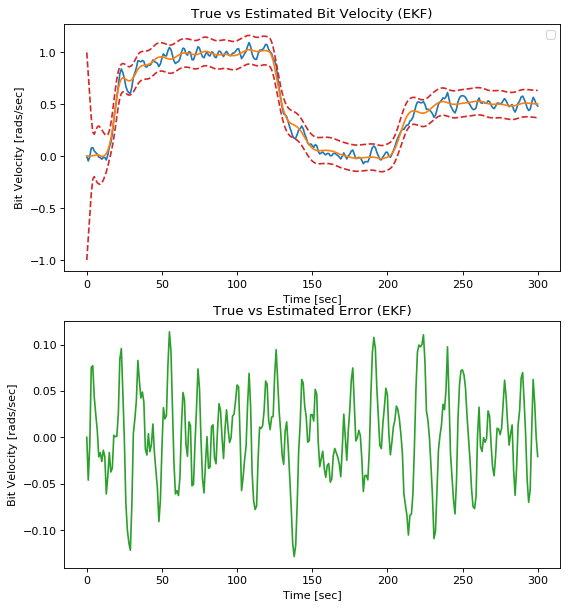

In [64]:
## Problem 6 - Extended Kalman Filter

# New nonlinear spring parameters
k1 = 2
k2 = 0.25

# Noise Covariances
W = 0.005 * np.identity(3)#You design this one. 
N = 0.02
Sig0 = np.identity(3) 

# Initial Condition
x_hat0 = [0,0,0]
states0 = np.r_[x_hat0, np.squeeze(np.asarray(Sig0.reshape(9,1)))]

# Ordinary Differential Equation for Kalman Filter
def ode_ekf(z,it):
    
    # Parse States
    theta_hat = z[0]
    omega_T_hat = z[1]
    omega_B_hat = z[2]
    Sig = np.matrix((z[3:]).reshape(3,3))
    
    # Interpolate input signal data
    iTorq = interp(it, t, Torq)
    iy_m = interp(it, t, y_m)
    
    # Compute Jacobians
    F = np.matrix([[0,1,-1],
                   [(-k1/J_T)-(3*k2/J_T)*theta_hat**2,-b/J_T,0],
                   [(k1/J_B)+(3*k2/J_B)*theta_hat**2,0,-b/J_B]
                  ])
    H = np.matrix([[0,1,0]])
    
    # Compute Kalman Gain
    L = (Sig * H.T* (1/N))
    
    # Compute EKF system matrices
    y_hat = omega_T_hat
    
    theta_hat_dot = (omega_T_hat
                    - omega_B_hat
                    + L[0] * (iy_m-y_hat))

    omega_T_hat_dot = omega_T_hat - omega_B_hat + L[0] * (iy_m-y_hat)
    omega_T_hat_dot =((iTorq/J_T)
                      - (b*omega_T_hat/J_T)
                      - (k1*theta_hat+k2*theta_hat**3)/J_T
                      + L[1] * (iy_m-y_hat))
    omega_B_hat_dot =(-(b*omega_B_hat/J_B)
                      + (k1*theta_hat+k2*theta_hat**3)/J_B
                      + L[2] * (iy_m-y_hat))
    
    # Riccati Equation
    Sig_dot = ((Sig*F.T) + (F*Sig) + W - Sig * H.T * (1/N) * H * Sig)
    
    # Concatenate LHS
    z_dot = np.r_[theta_hat_dot, omega_T_hat_dot, omega_B_hat_dot, Sig_dot.reshape(9,1)]
    
    return(np.squeeze(np.asarray(z_dot)))


# Integrate Extended Kalman Filter ODEs
z = odeint(ode_ekf, states0, t)

# Parse States
theta_hat = z[:,0]
omega_T_hat = z[:,1]
omega_B_hat = z[:,2]
Sig33 = z[:,-1]

omega_B_tilde = omega_B_true - omega_B_hat
omega_B_hat_upperbound = omega_B_hat + np.sqrt(Sig33)
omega_B_hat_lowerbound = omega_B_hat - np.sqrt(Sig33)

RMSE = np.sqrt(np.mean(np.power(omega_B_tilde,2)))
print('Extended Kalman Filter RMSE: ' + str(RMSE) + ' rad/s')


# Plot Results
plt.figure(num=3, figsize=(8, 9), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2,1,1)
#   Plot true and estimated bit velocity
plt.plot(t,omega_B_true, 'C0', label='True Bit Velocity')
plt.plot(t,omega_B_hat, 'C1', label='Est. Bit Velocity')
#   Plot estimated bit velocity plus/minus one sigma
plt.plot(t,omega_B_hat_upperbound, 'C3--', label='Upper STD Bound')
plt.plot(t,omega_B_hat_lowerbound, 'C3--', label='Lower STD Bound')

plt.title('True vs Estimated Bit Velocity (EKF)')
plt.xlabel('Time [sec]')
plt.ylabel('Bit Velocity [rads/sec]')
plt.legend('')

plt.subplot(2,1,2)
#   Plot error between true and estimated bit velocity
plt.plot(t, omega_B_tilde,'C2')

plt.title('True vs Estimated Error (EKF)')
plt.xlabel('Time [sec]')
plt.ylabel('Bit Velocity [rads/sec]')

plt.show()